In [11]:
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram
from math import pi, sqrt, sin, asin
import time

%matplotlib inline

In [12]:
def sprinkler(qc,q,a):
    qc.x(q[2])
    qc.x(a[0])
    qc.x(a[1])
    qc.x(a[2])
    qc.ccx(q[0],q[1],a[0])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[2],a[2])
    qc.mct([a[0],a[1],a[2],q[3]],a[3])
    qc.ccx(q[0],q[2],a[2])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[1],a[0])
    qc.x(a[2])
    qc.x(a[1])
    qc.x(a[0])
    qc.x(q[2])


In [13]:
def rotations():
    q=QuantumRegister(4)
    qc=QuantumCircuit(q)
    weights=[0.55,0.3,0.7]
    for i in range(len(weights)):
       theta=2.0*asin(sqrt(weights[i]))
       qc.ry(theta,q[i])
    qc.h(q[3])
    return qc

rot=rotations().to_gate()
invrot=rot.inverse()

In [14]:
def grover_circ():
    q=QuantumRegister(4)
    a=QuantumRegister(5)
    qc=QuantumCircuit(q,a)
    qc.x(a[3])
    qc.h(a[3])
    sprinkler(qc,q,a)
    qc.h(a[3])
    qc.x(a[3])
    qc.append(invrot,range(4))
    for i in range(q.size):
        qc.x(q[i])
    qc.mct([q[0],q[1],q[2],q[3]],a[4])
    qc.z(a[4])
    qc.mct([q[0],q[1],q[2],q[3]],a[4])
    for i in range(q.size):
        qc.x(q[i])
    qc.ry(2*pi,q[0]) 
    qc.append(rot,range(4))

    return qc

In [15]:
grover = grover_circ().to_gate()
cgrover = ggrover.control()

In [16]:
t = 5   # no. of counting qubits
n = 4   # no. of searching qubits

def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

invqft = qft(t).to_gate().inverse()


In [17]:
q=QuantumRegister(n)
a=QuantumRegister(5)
s=QuantumRegister(t)
c=ClassicalRegister(t)

qc = QuantumCircuit(s,q,a,c) # Circuit with n+t qubits and t classical bits

for qubit in range(t):
    qc.h(qubit)

qc.append(rot, range(t,n+t))

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrover, [qubit] + [*range(t, n+t+5)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(invqft, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))



In [18]:
backend = Aer.get_backend('qasm_simulator')
start = time.time()

job_sim = execute(qc, backend, shots=1000)
end = time.time()
print(end - start)

result_sim = job_sim.result()


1.7945680618286133


In [19]:
counts  = result_sim.get_counts()
weights={}
for  key, value in counts.items():
    theta=2*pi*int(key,2)/2**t
    newkey=round(2*sin(theta/2)**2,3)
    if newkey in weights:
        weights[newkey]=weights[newkey]+value
    else:
        weights[newkey]=value

In [20]:
weights

{0.0: 6,
 0.019: 8,
 2.0: 1,
 1.924: 1,
 1.831: 3,
 1.556: 3,
 1.383: 5,
 1.195: 12,
 1.0: 23,
 0.805: 183,
 0.617: 674,
 0.444: 40,
 0.293: 20,
 0.169: 13,
 0.076: 6,
 1.707: 1,
 1.981: 1}

In [16]:
qs={
 0.617: 681,
0.805: 183,
1.195: 14,
1.707: 4,
1.000: 22,
1.981: 2,
0.444: 46,
0.169: 8,
1.383: 8,
1.924: 4,
0.076: 3,
0.293: 15,
1.831: 2,
0.000: 1,
1.556: 5,
0.019: 2
}

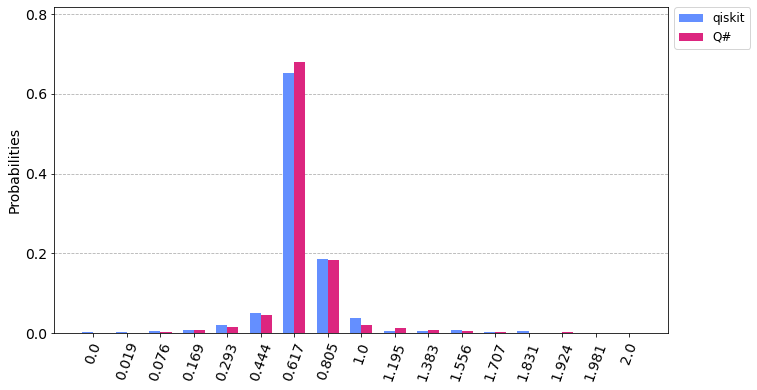

In [17]:
fig=plot_histogram([weights,qs],sort='asc',bar_labels=False, legend=['qiskit','Q#'],figsize =(11,6))
fig

In [18]:
fig.savefig("qwmc.pdf", bbox_inches='tight')